In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import boxcox1p
import pickle
from os import path
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

# data Visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px 
#from plotnine import ggplot, aes, geom_line, geom_point, facet_wrap, theme
import plotly.graph_objects as go
# Machine learning algorithms and model evaluation
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from skforecast.model_selection import backtesting_forecaster
#from skforecast.model_selection import grid_search_forecaster
#from skforecast.model_selection import bayesian_search_forecaster
#from lightgbm import LGBMRegressor
# Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler



1. Data Preprocessing:
Load the datasets


In [2]:
# Load the three datasets
average_hours = pd.read_csv('Resources/average-usual-weekly-hours-worked-women-15-years-and-older.csv')
employment_ratio = pd.read_csv("Resources/female-employment-to-population-ratio.csv")
wage_gap = pd.read_csv("Resources/gender-wage-gap-oecd.csv")
percapita_labor = pd.read_csv("Resources/female-labor-force-participation-rates-by-national-per-capita-income.csv")
school_years = pd.read_csv("Resources/mean-years-of-schooling-female.csv")
maternity_leave = pd.read_csv("Resources/paid-leave-at-least-14-weeks-mothers.csv")
labor_sector = pd.read_csv("Resources/share-of-female-workers-by-sector.csv")


In [3]:
# Columns and Rows for each of the dataset 
print(f'Shape of average_hours DataFrame: {average_hours.shape}')
print(f'Shape of employment_ratio DataFrame: {employment_ratio.shape}')
print(f'Shape of wage_gap DataFrame: {wage_gap.shape}')
print(f'Shape of percapita_labor DataFrame: {percapita_labor.shape}')
print(f'Shape of school_years DataFrame: {school_years.shape}')
print(f'Shape of maternity_leave DataFrame: {maternity_leave.shape}')
print(f'Shape of labor_sector DataFrame: {labor_sector.shape}')

Shape of average_hours DataFrame: (971, 4)
Shape of employment_ratio DataFrame: (3919, 4)
Shape of wage_gap DataFrame: (636, 4)
Shape of percapita_labor DataFrame: (7185, 6)
Shape of school_years DataFrame: (1502, 4)
Shape of maternity_leave DataFrame: (10206, 4)
Shape of labor_sector DataFrame: (2781, 6)


In [4]:
# Rename Columns to make it shorter
average_hours = average_hours.rename(columns={'Average weekly hours worked (women, 15+) (OECD Labor Force Statistics (2017))': 'Avg_Hours_Worked'})
employment_ratio = employment_ratio.rename(columns={'Employment to population ratio, 15+, female (%) (national estimate)': 'Emp_Pop_Ratio'})
wage_gap = wage_gap.rename(columns={'Gender wage gap (OECD 2017)': 'Gender_Wage_Gap'})
percapita_labor = percapita_labor.rename(columns={'Labor force participation rate, female (% of female population ages 15+) (modeled ILO estimate)': 'Labor_Force'})
school_years = school_years.rename(columns={'Mean years of schooling (ISCED 1 or higher), population 25+ years, female': 'School_Years_Mean'})
maternity_leave = maternity_leave.rename(columns={'Paid leave of at least 14 weeks available to mothers (1=yes; 0=no)': 'Paid_Leave'})
labor_sector = labor_sector.rename(columns={'Female share of employment in agriculture (%)': 'Argiculture','Female share of employment in industry (%)': 'Industry','Female share of employment in services (%)': 'Services'})


In [5]:
average_hours.dropna(inplace=True)
employment_ratio.dropna(inplace=True)


In [6]:
# Merge the datasets
merged_df= average_hours.merge(employment_ratio, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(wage_gap, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(percapita_labor, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(school_years, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(maternity_leave, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(labor_sector, on=['Entity', 'Code', 'Year'], how='outer')

# Check the result
print(merged_df.shape)


(11400, 14)


In [7]:
print(merged_df.isnull().sum())

Entity                                                     0
Code                                                     458
Year                                                       0
Avg_Hours_Worked                                       10512
Emp_Pop_Ratio                                           7716
Gender_Wage_Gap                                        10764
Labor_Force                                             4969
GDP per capita, PPP (constant 2017 international $)     4838
Continent                                              11115
School_Years_Mean                                       9898
Paid_Leave                                              1194
Argiculture                                             8675
Industry                                                8653
Services                                                8655
dtype: int64


In [8]:
#Drop colum "Continent"
merged_df = merged_df.drop("Continent", axis=1)

In [9]:
# Check for duplicates
duplicates = merged_df.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

Number of duplicates: 0


In [10]:
filtered_df = merged_df[merged_df['Code'].str.len()<=3]


In [11]:
# Check the data types of each column
print(filtered_df.dtypes)


Entity                                                  object
Code                                                    object
Year                                                     int64
Avg_Hours_Worked                                       float64
Emp_Pop_Ratio                                          float64
Gender_Wage_Gap                                        float64
Labor_Force                                            float64
GDP per capita, PPP (constant 2017 international $)    float64
School_Years_Mean                                      float64
Paid_Leave                                             float64
Argiculture                                            float64
Industry                                               float64
Services                                               float64
dtype: object


In [12]:
# Perform some basic EDA
print(filtered_df.describe())


               Year  Avg_Hours_Worked  Emp_Pop_Ratio  Gender_Wage_Gap  \
count  10778.000000        888.000000    3662.000000       636.000000   
mean    1997.015866         35.485752      44.861098        19.385535   
std       15.581715          4.047832      14.312533        10.053530   
min     1960.000000         24.038079       2.500000         0.000000   
25%     1984.000000         32.523503      36.909500        13.200000   
50%     1997.000000         35.616393      46.108000        17.900000   
75%     2011.000000         38.548941      53.131750        23.400000   
max     2023.000000         44.813507      94.500000        52.800000   

       Labor_Force  GDP per capita, PPP (constant 2017 international $)  \
count  5951.000000                                        6085.000000     
mean     49.674714                                       18408.744201     
std      15.605830                                       20667.723060     
min       4.948000                        

In [13]:
# Define numerical and catrgorical columns 
numerical_cols = ['Year', 'Avg_Hours_Worked', 'Emp_Pop_Ratio', 'Gender_Wage_Gap', 
                  'Labor_Force', 'GDP per capita, PPP (constant 2017 international $)', 
                  'School_Years_Mean', 'Paid_Leave', 'Argiculture', 'Industry', 
                  'Services']

categorical_cols = ['Entity', 'Code']

In [14]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

# Impute null values in numerical columns using KNNImputer
imputer_num = KNNImputer(n_neighbors=5)
imputed_num_data = imputer_num.fit_transform(filtered_df[numerical_cols])

# One-Hot Encode categorical columns
#ohe = OneHotEncoder(handle_unknown='ignore')
#encoded_array = ohe.fit_transform(filtered_df[categorical_cols])
#encoded_df = pd.DataFrame(encoded_array.toarray(), columns=ohe.get_feature_names_out(categorical_cols))

# Concatenate imputed numerical columns with one-hot encoded categorical columns
#df_encoded = pd.concat([pd.DataFrame(imputed_num_data, columns=numerical_cols), encoded_df], axis=1)


In [15]:
# Check for null values before imputation
print("Null values before imputation:")
print(filtered_df[numerical_cols].isnull().sum())

#imputed_num_data = imputer_num.fit_transform(filtered_df[numerical_cols])

# Check imputed data for null values
imputed_num_df = pd.DataFrame(imputed_num_data, columns=numerical_cols)
imputed_num_df.reset_index(inplace=True, drop=True)
cat_df= filtered_df[categorical_cols]
cat_df.reset_index(inplace=True, drop=True)

print(cat_df.isnull().sum())
print("Null values after imputation:")
print(imputed_num_df.isnull().sum())

Null values before imputation:
Year                                                       0
Avg_Hours_Worked                                        9890
Emp_Pop_Ratio                                           7116
Gender_Wage_Gap                                        10142
Labor_Force                                             4827
GDP per capita, PPP (constant 2017 international $)     4693
School_Years_Mean                                       9277
Paid_Leave                                               626
Argiculture                                             8088
Industry                                                8075
Services                                                8077
dtype: int64
Entity    0
Code      0
dtype: int64
Null values after imputation:
Year                                                   0
Avg_Hours_Worked                                       0
Emp_Pop_Ratio                                          0
Gender_Wage_Gap                                

In [16]:
# concatenate the imputed numerical columns with the original categorical columns
# pd.DataFrame(imputed_num_data, columns=numerical_cols)
imputed_df = pd.concat([imputed_num_df, cat_df], axis=1)
#imputed_df[categorical_cols] = imputed_df[categorical_cols].astype('category')



In [17]:
imputed_df

,Year,Avg_Hours_Worked,Emp_Pop_Ratio,Gender_Wage_Gap,Labor_Force,"GDP per capita, PPP (constant 2017 international $)",School_Years_Mean,Paid_Leave,Argiculture,Industry,Services,Entity,Code
0,2001.0,31.062685,51.5200,14.30,55.0490,38690.570000,10.730948,0.0,32.33,20.48,51.92,Australia,AUS
1,2002.0,30.964121,51.8620,15.00,55.2550,39775.270000,10.730948,0.0,30.90,20.37,52.06,Australia,AUS
2,2003.0,30.929489,52.5930,13.00,55.9260,40535.668000,10.589112,0.0,30.12,20.54,52.29,Australia,AUS
3,2004.0,31.107463,52.6220,14.40,55.6910,41798.720000,11.357820,0.0,32.09,19.74,52.27,Australia,AUS
4,2005.0,31.109187,54.0130,15.80,56.9770,42595.430000,11.411570,0.0,30.90,19.89,52.64,Australia,AUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10773,2011.0,37.653074,57.6146,6.00,64.9358,6340.080160,10.107556,0.0,28.78,31.71,52.79,Taiwan,TWN
10774,2012.0,36.959587,50.1852,4.36,50.9186,10043.378100,9.086946,0.2,27.52,31.54,53.07,Taiwan,TWN
10775,2013.0,36.470889,43.4492,3.80,60.2752,7892.852420,6.645424,0.6,27.99,31.60,53.35,Taiwan,TWN
10776,2014.0,36.433699,54.1570,5.80,47.1906,7808.817268,7.506264,0.4,28.60,31.43,53.59,Taiwan,TWN


In [18]:
print(imputed_df.isnull().sum())

Year                                                   0
Avg_Hours_Worked                                       0
Emp_Pop_Ratio                                          0
Gender_Wage_Gap                                        0
Labor_Force                                            0
GDP per capita, PPP (constant 2017 international $)    0
School_Years_Mean                                      0
Paid_Leave                                             0
Argiculture                                            0
Industry                                               0
Services                                               0
Entity                                                 0
Code                                                   0
dtype: int64


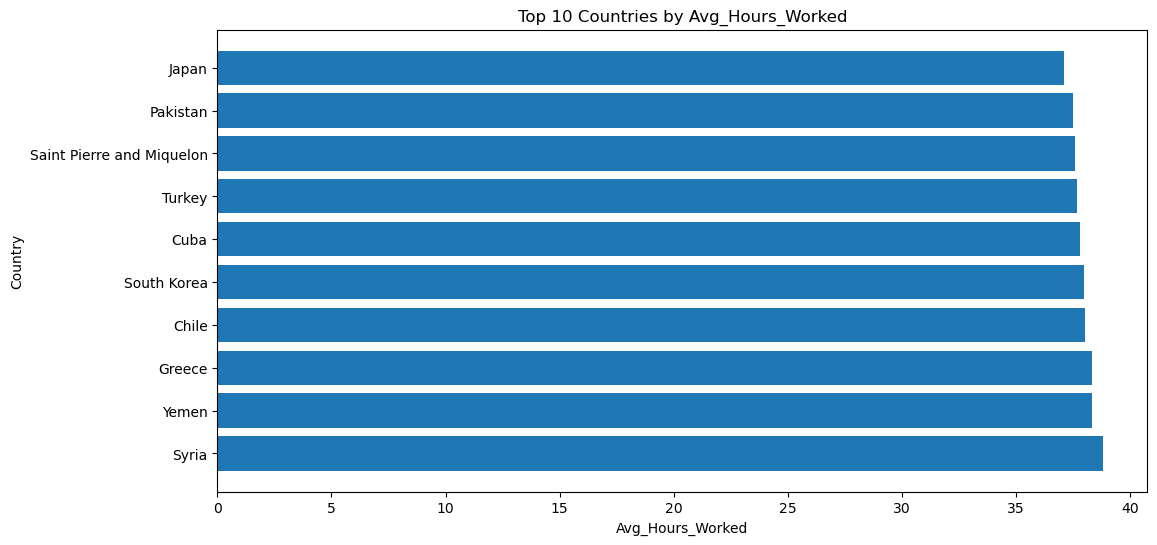

In [19]:
# Get the top 10 countries by Average Hours Worked  
top_countries = imputed_df.groupby('Entity')['Avg_Hours_Worked'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Avg_Hours_Worked')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Avg_Hours_Worked'])
plt.title("Top 10 Countries by Avg_Hours_Worked")
plt.xlabel("Avg_Hours_Worked")
plt.ylabel("Country")
plt.show()

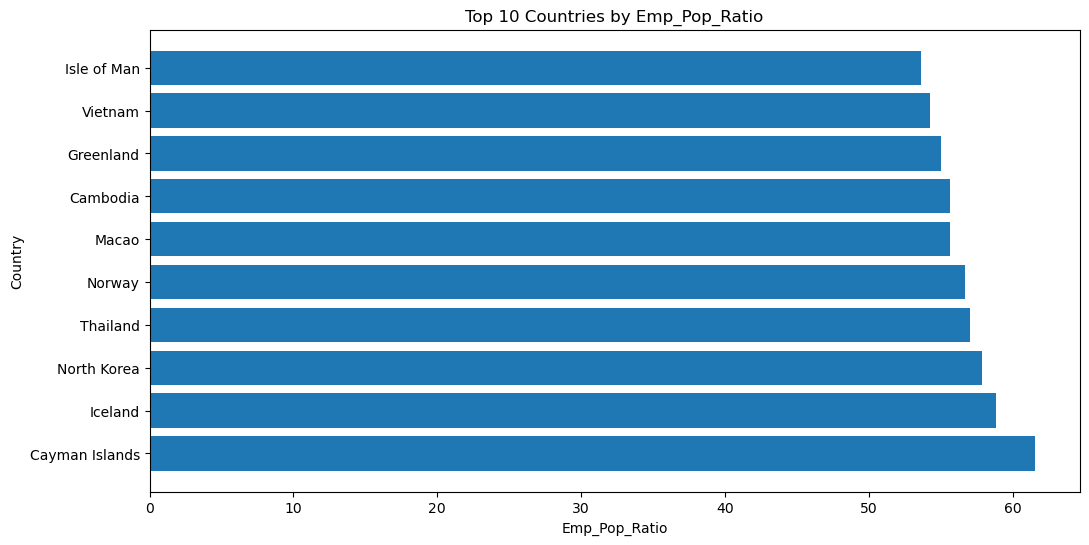

In [20]:
# Get the top 10 countries by Emp_Pop_Ratio  
top_countries = imputed_df.groupby('Entity')['Emp_Pop_Ratio'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Emp_Pop_Ratio')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Emp_Pop_Ratio'])
plt.title("Top 10 Countries by Emp_Pop_Ratio")
plt.xlabel("Emp_Pop_Ratio")
plt.ylabel("Country")
plt.show()

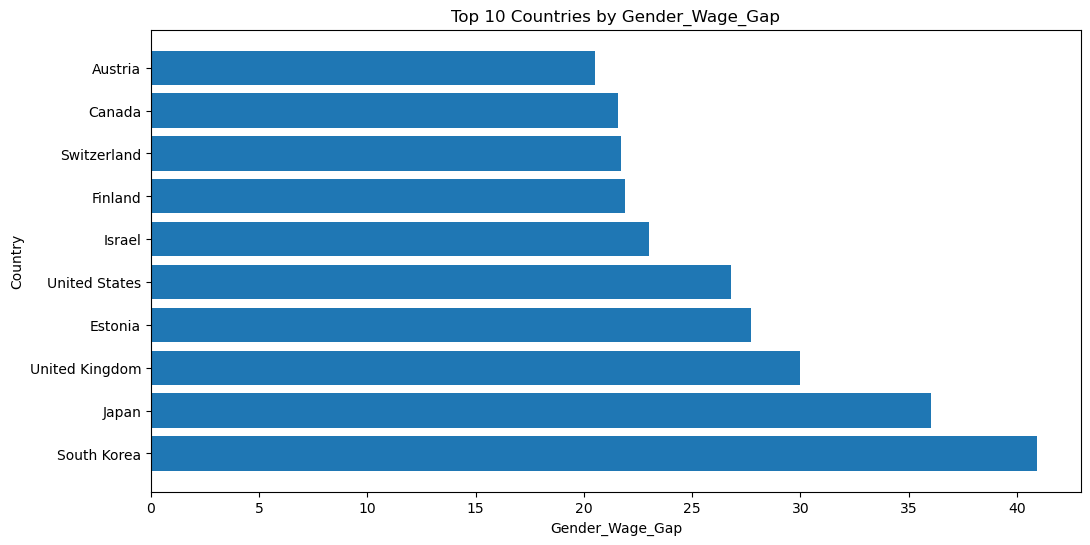

In [21]:
# Get the top 10 countries by Gender_Wage_Gap
top_countries = merged_df.groupby('Entity')['Gender_Wage_Gap'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Gender_Wage_Gap')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Gender_Wage_Gap'])
plt.title("Top 10 Countries by Gender_Wage_Gap")
plt.xlabel("Gender_Wage_Gap")
plt.ylabel("Country")
plt.show()

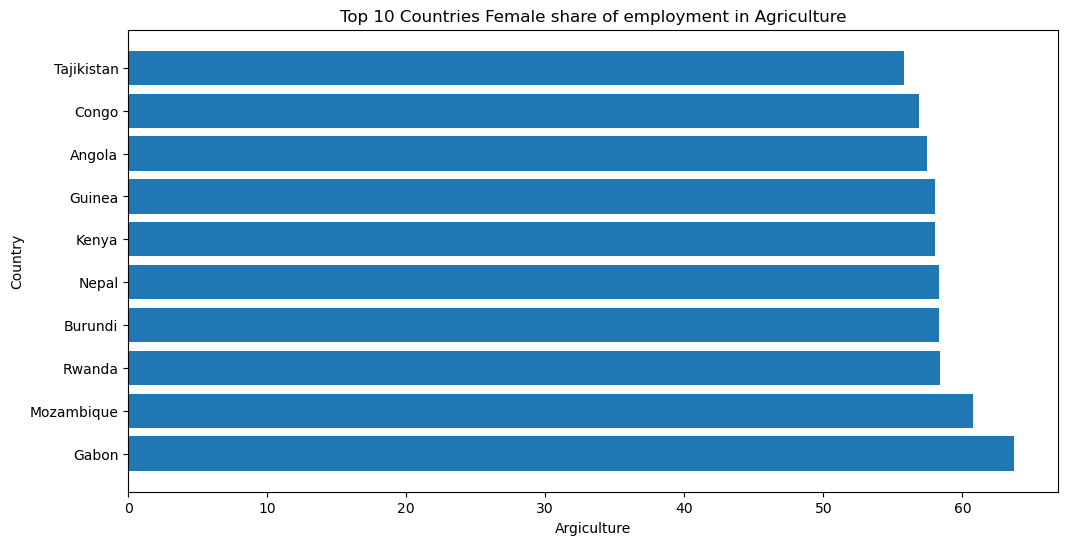

In [22]:
# Get the top 10 countries by Argiculture
top_countries = merged_df.groupby('Entity')['Argiculture'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Argiculture')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Argiculture'])
plt.title("Top 10 Countries Female share of employment in Agriculture")
plt.xlabel("Argiculture")
plt.ylabel("Country")
plt.show()

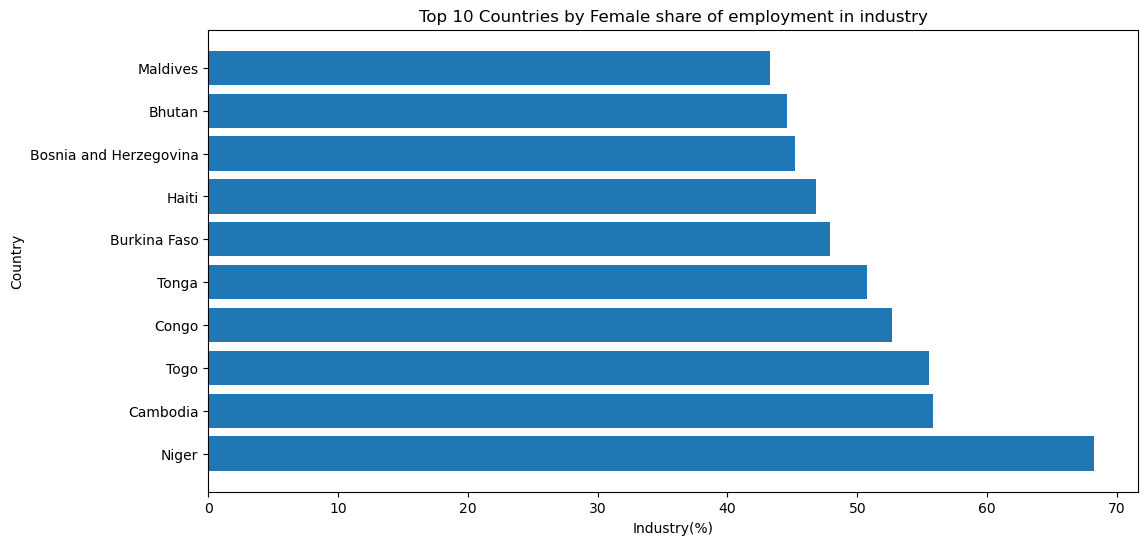

In [23]:
# Get the top 10 countries by Industry
top_countries = merged_df.groupby('Entity')['Industry'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Industry')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Industry'])
plt.title("Top 10 Countries by Female share of employment in industry")
plt.xlabel("Industry(%)")
plt.ylabel("Country")
plt.show()

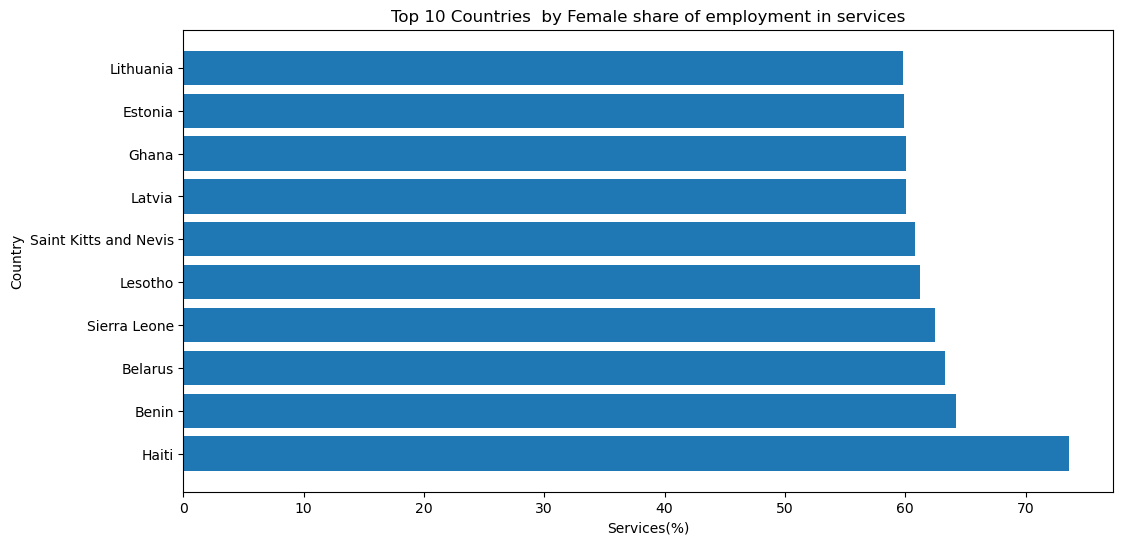

In [24]:
# Get the top 10 countries by Services
top_countries = merged_df.groupby('Entity')['Services'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Services')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Services'])
plt.title("Top 10 Countries  by Female share of employment in services")
plt.xlabel("Services(%)")
plt.ylabel("Country")
plt.show()

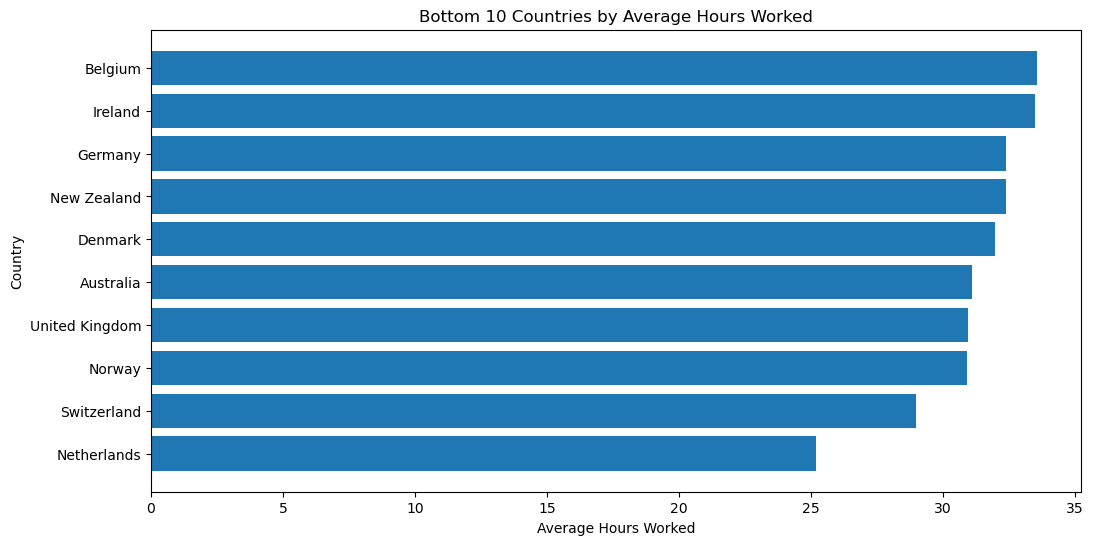

In [25]:

# Get the bottom 10 countries by average hours worked
bottom_countries = merged_df.groupby('Entity')['Avg_Hours_Worked'].mean().reset_index()
bottom_countries = bottom_countries.nsmallest(10, 'Avg_Hours_Worked')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(bottom_countries['Entity'], bottom_countries['Avg_Hours_Worked'])
plt.title("Bottom 10 Countries by Average Hours Worked")
plt.xlabel("Average Hours Worked")
plt.ylabel("Country")
plt.show()

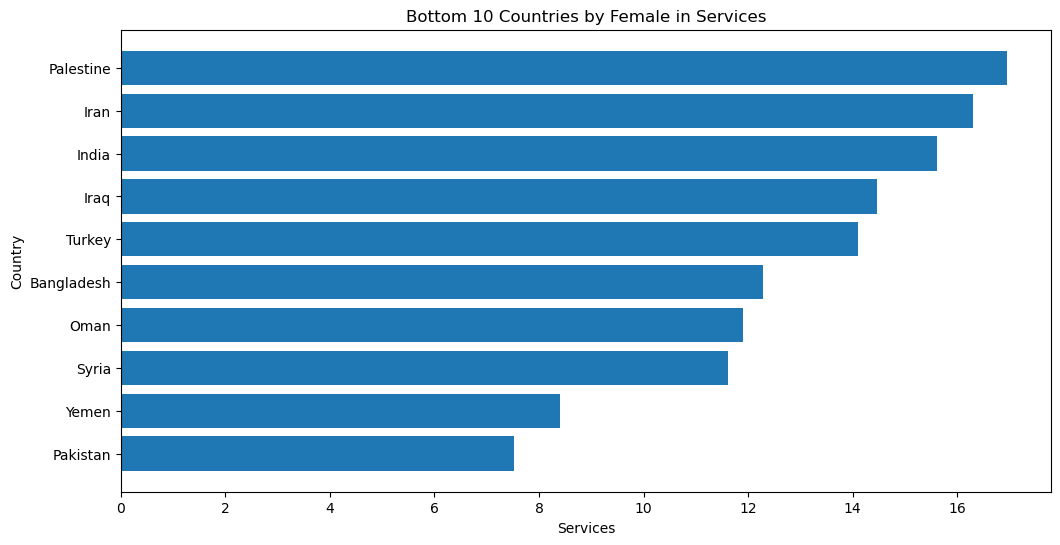

In [26]:
# Get the top 10 countries by Services
bottom_countries = merged_df.groupby('Entity')['Services'].mean().reset_index()
bottom_countries = bottom_countries.nsmallest(10, 'Services')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(bottom_countries['Entity'], bottom_countries['Services'])
plt.title("Bottom 10 Countries by Female in Services")
plt.xlabel("Services")
plt.ylabel("Country")
plt.show()

In [27]:
# Define the columns that will be used to create the professional wellbeing score
columns_to_use = ['Avg_Hours_Worked', 'Emp_Pop_Ratio', 'Gender_Wage_Gap', 
                  'Labor_Force', 'GDP per capita, PPP (constant 2017 international $)', 
                  'School_Years_Mean', 'Paid_Leave', 'Argiculture', 'Industry', 
                  'Services']

# Scale the columns using Min-Max Scaler to have values between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
imputed_df[columns_to_use] = scaler.fit_transform(imputed_df[columns_to_use])

# Calculate the professional wellbeing score as the average of the scaled columns
imputed_df['Professional_Wellbeing_Score'] = imputed_df[columns_to_use].mean(axis=1)

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
imputed_df[columns_to_use] = scaler.fit_transform(imputed_df[columns_to_use])

In [29]:
from sklearn.model_selection import train_test_split

X = imputed_df[columns_to_use]
y = imputed_df['Professional_Wellbeing_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

In [31]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

In [33]:
from sklearn.metrics import mean_squared_error, r2_score

print("Linear Regression:")
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("R2:", r2_score(y_test, y_pred_lr))

print("\nRandom Forest Regressor:")
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R2:", r2_score(y_test, y_pred_rf))

print("\nGradient Boosting Regressor:")
print("MSE:", mean_squared_error(y_test, y_pred_gb))
print("R2:", r2_score(y_test, y_pred_gb))

Linear Regression:
MSE: 6.22747124967587e-32
R2: 1.0

Random Forest Regressor:
MSE: 8.504251360606591e-05
R2: 0.9841876509160756

Gradient Boosting Regressor:
MSE: 6.958849219496495e-05
R2: 0.9870610888113232


In [34]:
#Hyperparameter Tuning 
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': np.arange(50, 251, 50),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': np.arange(3, 8),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11)
}

gb_model = GradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

y_pred_best = best_model.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("Best Parameters:", best_params)
print("MSE:", mse_best)
print("R2:", r2_best)

Best Parameters: {'n_estimators': 250, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_depth': 4, 'learning_rate': 0.11555555555555555}
MSE: 3.0609370876092964e-05
R2: 0.9943086576700437


In [52]:
# Define the input features (X) and the target variable (y)
X = imputed_df[columns_to_use]
y = imputed_df['Professional_Wellbeing_Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer with a single neuron

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
270/270 - 1s - 2ms/step - loss: 0.0132
Epoch 2/50
270/270 - 0s - 609us/step - loss: 0.0019
Epoch 3/50
270/270 - 0s - 626us/step - loss: 0.0011
Epoch 4/50
270/270 - 0s - 628us/step - loss: 7.6848e-04
Epoch 5/50
270/270 - 0s - 678us/step - loss: 5.6031e-04
Epoch 6/50
270/270 - 0s - 678us/step - loss: 4.6399e-04
Epoch 7/50
270/270 - 0s - 670us/step - loss: 3.8713e-04
Epoch 8/50
270/270 - 0s - 611us/step - loss: 3.1047e-04
Epoch 9/50
270/270 - 0s - 637us/step - loss: 2.5558e-04
Epoch 10/50
270/270 - 0s - 621us/step - loss: 2.2738e-04
Epoch 11/50
270/270 - 0s - 619us/step - loss: 1.9917e-04
Epoch 12/50
270/270 - 0s - 687us/step - loss: 1.6664e-04
Epoch 13/50
270/270 - 0s - 665us/step - loss: 1.5810e-04
Epoch 14/50
270/270 - 0s - 640us/step - loss: 1.5574e-04
Epoch 15/50
270/270 - 0s - 674us/step - loss: 1.3107e-04
Epoch 16/50
270/270 - 0s - 662us/step - loss: 1.1372e-04
Epoch 17/50
270/270 - 0s - 624us/step - loss: 1.0922e-04
Epoch 18/50
270/270 - 0s - 621us/step - loss: 9.7523e-

In [54]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Flatten y_pred and y_test to 1-dimensional arrays
y_pred = y_pred.flatten()
y_test = y_test.values.flatten()

# Evaluate the model using Mean Squared Error (MSE)
mse = np.mean((y_pred - y_test) ** 2)
print("MSE:", mse)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
MSE: 7.790306932280263e-06


In [ ]:
imputed_df

In [58]:
import gradio as gr

def get_professional_wellbeing_score(entity_name):
    # Search for the entity name in the dataset
    entity_row = imputed_df[imputed_df["Entity"] == entity_name]
    if entity_row.empty:
        print(f"Entity '{entity_name}' not found in dataset")
        return "Entity not found"
    else:
        # Return the professional wellbeing score for the entity
        print(f"Entity '{entity_name}' found in dataset")
        return entity_row["Professional_Wellbeing_Score"].values[0]

# Create the Gradio app
gr_interface = gr.Interface(
    fn=get_professional_wellbeing_score,
    inputs="text",
    outputs="text",
    title="Professional Wellbeing Score Lookup",
    description="Enter an entity name to get its professional wellbeing score"
)

# Launch the Gradio app
gr_interface.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
